The goal of this is to get a rough model of the number of syllables in a word based on its frequency in a corpus.
It should output two pickles, a dict that gives corpus frequency and a function that gives the approximate syllables based on the frequency.

Note that the whole premise of this is that frequency is a better proxy for the grade level difficulty than syllables. Thus, we don't expect the fit between frequency and syllables to be all that great.

In [328]:
from nltk import FreqDist

In [330]:
from nltk.corpus import brown

In [333]:
brown.categories()

[u'adventure',
 u'belles_lettres',
 u'editorial',
 u'fiction',
 u'government',
 u'hobbies',
 u'humor',
 u'learned',
 u'lore',
 u'mystery',
 u'news',
 u'religion',
 u'reviews',
 u'romance',
 u'science_fiction']

In [375]:
genres=[u'adventure',
 u'fiction',
 u'humor',
 u'mystery',
 u'reviews',
 u'lore',
 u'romance',
 u'science_fiction']

One could insert in any corpus in the form of a list of the words in the copus as `words`

In [376]:
words = brown.words(categories=genres)

Only alpha-numeric words will be included. This might not work well for other languages if you don't convert to ascii

In [377]:
fdist=FreqDist(word.lower() for word in words if word.isalpha())


In [378]:
fdist.most_common(n=10)

[(u'the', 24472),
 (u'and', 11480),
 (u'of', 10748),
 (u'to', 9719),
 (u'a', 9465),
 (u'in', 6936),
 (u'he', 6043),
 (u'was', 5501),
 (u'it', 3999),
 (u'that', 3979)]

In [420]:
fdist_dict={i[0]:i[1] for i in fdist.most_common()}

Counting the syllables is done via a lookup in nlkt's pronuciation dictionary. There are definitely better ways to do this. The pronuciation dictionary doesn't have lots of words, so we're only using a subset of the data. I think that using this subset of the data shouldn't hurt the analysis.

In [27]:
from nltk.corpus import cmudict

In [32]:
prondict=cmudict.dict()

In [380]:
len(prondict)

123455

In [379]:
len(fdist.most_common())

24857

In [386]:
q=0
for i in fdist.keys():
    try:
        prondict[i]
    except KeyError:
        q+=1
print(q)

3283


In [61]:
import pandas as pd
import numpy as np

In [75]:
def count_syllables(sylist):
    return sum([i[-1].isdigit() for i  in sylist])

In [406]:
syldict={idx:count_syllables(prondict[idx][0]) for idx in prondict.keys()}

In [407]:
syllabledict={idx:[syldict[idx],fdist.get(idx)] for idx in fdist.keys() if (syldict.has_key(idx) and syldict[idx]>0)}

In [408]:
wordf=pd.DataFrame(syllabledict,index=['syllables','frequency']).T

In [409]:
wordf.head()

,syllables,frequency
a,1,9465
aaron,2,4
ab,1,1
aback,2,2
abandon,3,5


In [410]:
wordf.dropna().shape==wordf.shape

True

In [416]:
sylmean=wordf.groupby('syllables').mean()
sylmean
    

,frequency
syllables,
1,56.699569
2,8.299604
3,4.683581
4,3.631628
5,3.044313
6,2.050000
7,1.000000


In [105]:
import matplotlib.pyplot as plt

In [227]:
sylmean

array([[  1.        ,  50.37262262],
       [  2.        ,   7.86924439],
       [  3.        ,   4.08668654],
       [  4.        ,   2.84931507],
       [  5.        ,   2.58424908],
       [  6.        ,   1.57142857],
       [  7.        ,   1.        ]])

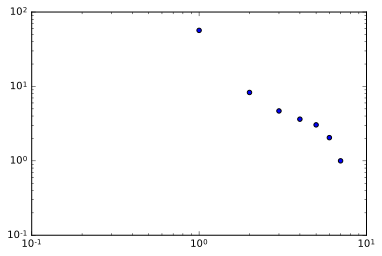

In [418]:
plt.scatter(sylmean.index,sylmean)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [419]:
import statsmodels.api as sm

In [421]:
olsmodel=sm.OLS(np.log(sylmean.index.values),sm.add_constant(np.log(sylmean)))
olsfit=olsmodel.fit()
olsfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     105.1
Date:                Thu, 31 Mar 2016   Prob (F-statistic):           0.000152
Time:                        12:25:32   Log-Likelihood:                 4.0780
No. Observations:                   7   AIC:                            -4.156
Df Residuals:                       5   BIC:                            -4.264
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.0244      0.099     20.405      0.000         1.769     2.279
frequency     -0.5219      0.051    -10.250      0.000        -0.653    -0.391
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.546
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.582
Skew:                          -0.339   Prob(JB):                        0.748
Kurtosis:                       1.761   Cond. No.                         3.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This isn't automated. I did some rounding in my head because it looked reasonable. If you change the corpus and the values change, you need to change the function below too.

In [449]:
def equiv_sylb(freq):
    import numpy as np
    return np.exp(2)/np.sqrt(freq)

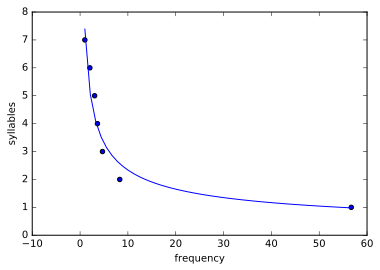

In [428]:
XX=np.linspace(sylmean['frequency'].min(),sylmean['frequency'].max())
plt.scatter(sylmean,sylmean.index.values)
plt.plot(XX,equiv_sylb(XX))
plt.xlabel('frequency')
plt.ylabel('syllables')
plt.show()

In [429]:
import pickle

In [453]:
with open('equiv_sylb.py','wb') as f:
    f.write('import numpy as np\n')
    f.write(inspect.getsource(equiv_sylb))

In [437]:
with open('frequency_dict.pkl','wb') as f:
    pickle.dump(fdist_dict, f)